In [154]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [155]:
#import data

#train dataset
train_raw = pd.read_csv('TRAIN.csv')
train_emb = pd.read_csv('384EMBEDDINGS_TRAIN.csv')
train_tfidf = pd.read_csv('TFIDF_TRAIN.csv')

#valid dataset
validation_raw = pd.read_csv('VALIDATION.csv')
validation_emb = pd.read_csv('384EMBEDDINGS_VALIDATION.csv')
validation_tfidf = pd.read_csv('TFIDF_VALIDATION.csv')

#test dataset
test_raw = pd.read_csv('TEST_NO_LABELS.csv')
test_emb = pd.read_csv('384EMBEDDINGS_TEST.csv')
test_tfidf = pd.read_csv('TFIDF_TEST.csv')


In [157]:
# List of all datasets
datasets = [train_raw, train_emb, train_tfidf, validation_raw, validation_emb, validation_tfidf, test_raw, test_emb, test_tfidf]

# Drop 'Unnamed' column from each dataset
for dataset in datasets:
    if 'Unnamed: 0' in dataset.columns:
        dataset.drop(columns=['Unnamed: 0'], inplace=True)


In [158]:
# Check basic info about the training dataset
print(train_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43003 entries, 0 to 43002
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dr-id-adjusted       43003 non-null  int64  
 1   dr_id_gender         43003 non-null  float64
 2   review-text-cleaned  43003 non-null  object 
 3   rating               43003 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB
None


In [159]:
# Check the distribution of sentiment labels
print(train_raw['rating'].value_counts())

rating
 1    30874
-1    12129
Name: count, dtype: int64


In [160]:
# gender counts in training
train_raw['dr_id_gender'].value_counts()

dr_id_gender
1.0    27511
0.0    12141
2.0     3351
Name: count, dtype: int64

In [187]:
gender_rating_distribution = train_raw.groupby('dr_id_gender')['rating'].value_counts().unstack(fill_value=0)
# Display the distribution
print(gender_rating_distribution)

rating          -1      1
dr_id_gender             
0.0           3828   8313
1.0           7498  20013
2.0            803   2548


In [176]:
# gender counts in training
validation_raw['dr_id_gender'].value_counts()

dr_id_gender
1.0    3584
0.0    1497
2.0     419
Name: count, dtype: int64

In [161]:
male_data = train_raw[train_raw['dr_id_gender'] == 1.0]
female_data = train_raw[train_raw['dr_id_gender'] == 0.0]
unknown_gender_data = train_raw[train_raw['dr_id_gender'] == 2.0]

In [162]:
male_indices = validation_raw[validation_raw['dr_id_gender'] == 1.0].index
female_indices = validation_raw[validation_raw['dr_id_gender'] == 2.0].index
unknown_gender_indices = validation_raw[validation_raw['dr_id_gender'] == 2.0].index

validation_male_tfidf = validation_tfidf.iloc[male_indices]
validation_female_tfidf = validation_tfidf.iloc[female_indices]
validation_unknown_tfidf = validation_tfidf.iloc[unknown_gender_indices]

validation_male_emb = validation_emb.iloc[male_indices]
validation_female_emb = validation_emb.iloc[female_indices]
validation_unknown_emb = validation_emb.iloc[unknown_gender_indices]


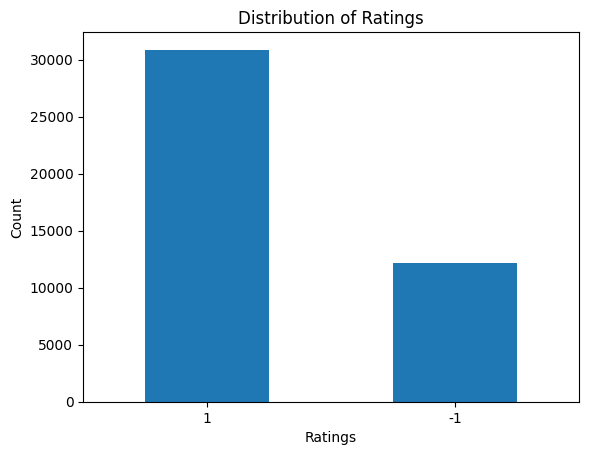

In [163]:
import matplotlib.pyplot as plt

ratings = train_raw['rating'].value_counts()

ratings.plot(kind='bar')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotates x-axis labels for better display
plt.title('Distribution of Ratings')
plt.show()

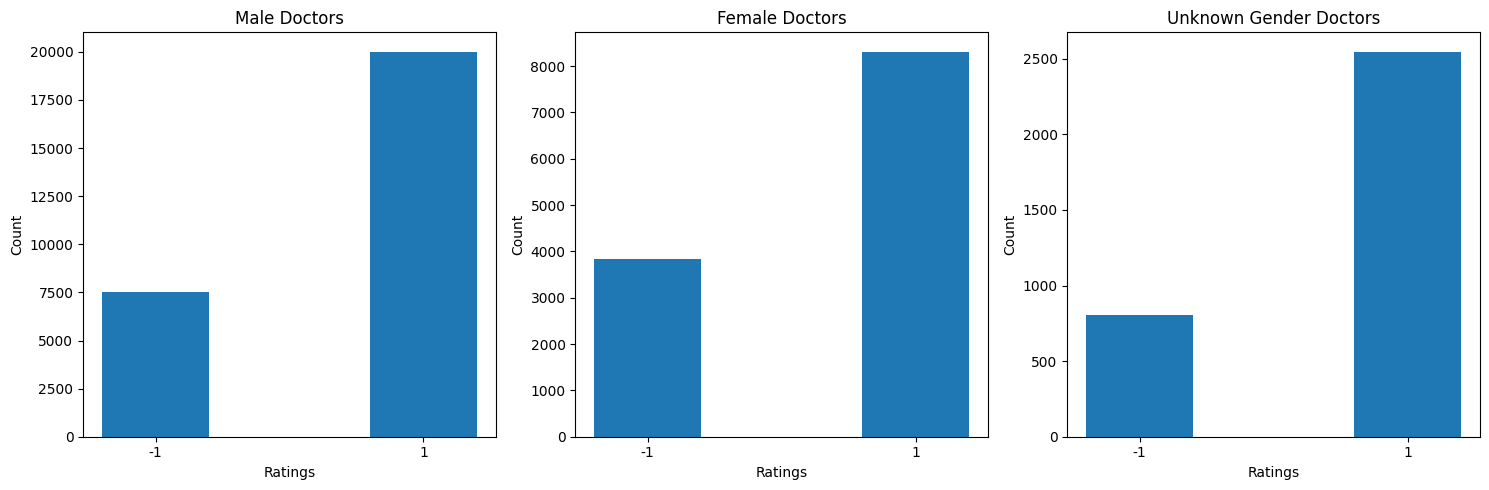

In [164]:
import matplotlib.pyplot as plt

# Define a figure and layout
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Male data plot
male_ratings = male_data['rating'].value_counts()
ax[0].bar(male_ratings.index, male_ratings.values)
ax[0].set_xlabel('Ratings')
ax[0].set_ylabel('Count')
ax[0].set_title('Male Doctors')
ax[0].set_xticks([-1, 1])
ax[0].set_xticklabels(['-1', '1'])

# Female data plot
female_ratings = female_data['rating'].value_counts()
ax[1].bar(female_ratings.index, female_ratings.values)
ax[1].set_xlabel('Ratings')
ax[1].set_ylabel('Count')
ax[1].set_title('Female Doctors')
ax[1].set_xticks([-1, 1])
ax[1].set_xticklabels(['-1', '1'])

# Unknown gender data plot
unknown_gender_ratings = unknown_gender_data['rating'].value_counts()
ax[2].bar(unknown_gender_ratings.index, unknown_gender_ratings.values)
ax[2].set_xlabel('Ratings')
ax[2].set_ylabel('Count')
ax[2].set_title('Unknown Gender Doctors')
ax[2].set_xticks([-1, 1])
ax[2].set_xticklabels(['-1', '1'])

# Ensure layouts are non-overlapping
plt.tight_layout()
plt.show()


# Baseline Model 
## Zero R

In [165]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Initialize the ZeroR classifier
zero_r = DummyClassifier(strategy='most_frequent')

# Fit on training data
zero_r.fit(train_raw[['review-text-cleaned']], train_raw['rating'])

# Predict on validation data
y_pred = zero_r.predict(validation_raw[['review-text-cleaned']])
accuracy = accuracy_score(validation_raw['rating'], y_pred)
print(f'ZeroR Classifier Accuracy on Validation Data: {accuracy * 100:.2f}%')
print("\n")
# Check accuracy on gender subsets
genders = [1.0, 0.0, 2.0]  # 1.0: male, 0.0: female, 2.0: unknown 

for gender in genders:
    subset_data = validation_raw[validation_raw['dr_id_gender'] == gender]
    y_true_subset = subset_data['rating']
    y_pred_subset = zero_r.predict(subset_data[['review-text-cleaned']])
    accuracy_subset = accuracy_score(y_true_subset, y_pred_subset)
    if gender == 1.0:
        print(f'ZeroR Classifier Accuracy for Males: {accuracy_subset * 100:.2f}%')
    elif gender == 0.0:
        print(f'ZeroR Classifier Accuracy for Females: {accuracy_subset * 100:.2f}%')
    elif gender == 2.0:
        print(f'ZeroR Classifier Accuracy for Unknown Gender : {accuracy_subset * 100:.2f}%')


ZeroR Classifier Accuracy on Validation Data: 73.42%


ZeroR Classifier Accuracy for Males: 72.57%
ZeroR Classifier Accuracy for Females: 73.81%
ZeroR Classifier Accuracy for Unknown Gender : 79.24%


# Supervised Learning 

## Multi Layer Perceptron (MLP)

### MLP on tfidf

In [150]:
#multilayer perceptron on TFIDF
MLP_tfidf = MLPClassifier(hidden_layer_sizes=(400, 200, 100, 50), learning_rate='adaptive', max_iter=100, early_stopping=True)
MLP_tfidf.fit(train_tfidf, train_raw['rating'])
accuracy = MLP_tfidf.score(validation_tfidf, validation_raw['rating'])
print("Accuracy of MLP (tfidf): ", accuracy)

Accuracy of MLP (tfidf):  0.9027272727272727


In [151]:
confusion_matrix(validation_raw['rating'], MLP_tfidf.predict(validation_tfidf))

array([[1258,  204],
       [ 331, 3707]])

In [168]:
print(classification_report(validation_raw['rating'], MLP_tfidf.predict(validation_tfidf)))

              precision    recall  f1-score   support

          -1       0.79      0.86      0.82      1462
           1       0.95      0.92      0.93      4038

    accuracy                           0.90      5500
   macro avg       0.87      0.89      0.88      5500
weighted avg       0.91      0.90      0.90      5500



### MLP on emb

In [147]:
#multilayer perceptron on emb
MLP_emb = MLPClassifier(hidden_layer_sizes=(400, 200, 100, 50), learning_rate='adaptive', max_iter=100, early_stopping=True)
MLP_emb.fit(train_emb, train_raw['rating'])
accuracy = MLP_emb.score(validation_emb, validation_raw['rating'])
print("Accuracy of MLP (emb): ", accuracy)

Accuracy of MLP (emb):  0.9178181818181819


In [148]:
confusion_matrix(validation_raw['rating'], MLP_emb.predict(validation_emb))

array([[1220,  242],
       [ 210, 3828]])

In [169]:
print(classification_report(validation_raw['rating'], MLP_emb.predict(validation_emb)))

              precision    recall  f1-score   support

          -1       0.85      0.83      0.84      1462
           1       0.94      0.95      0.94      4038

    accuracy                           0.92      5500
   macro avg       0.90      0.89      0.89      5500
weighted avg       0.92      0.92      0.92      5500



## Support Vector Machine (SVM)

### SVM on tfidf

In [67]:
SVM_tfidf = svm.SVC()
SVM_tfidf.fit(train_tfidf, train_raw['rating'])
accuracy = SVM_tfidf.score(validation_tfidf, validation_raw['rating'])
print("Accuracy of SVM (TFIDF): ", accuracy)

Accuracy of SVM (TFIDF):  0.9107272727272727


In [144]:
confusion_matrix(validation_raw['rating'], SVM_tfidf.predict(validation_tfidf))

array([[1257,  205],
       [ 286, 3752]])

In [172]:
print(classification_report(validation_raw['rating'], SVM_tfidf.predict(validation_tfidf)))

              precision    recall  f1-score   support

          -1       0.81      0.86      0.84      1462
           1       0.95      0.93      0.94      4038

    accuracy                           0.91      5500
   macro avg       0.88      0.89      0.89      5500
weighted avg       0.91      0.91      0.91      5500



### SVM on emb

In [111]:
#support vector machine on embeddings
SVM_emb = svm.SVC()
SVM_emb.fit(train_emb, train_raw['rating'])
accuracy = SVM_emb.score(validation_emb, validation_raw['rating'])
print("Accuracy of SVM (Emb): ", accuracy)

Accuracy of SVM (Emb):  0.926


In [145]:
confusion_matrix(validation_raw['rating'], SVM_emb.predict(validation_emb))

array([[1245,  217],
       [ 190, 3848]])

In [173]:
print(classification_report(validation_raw['rating'], SVM_emb.predict(validation_emb)))

              precision    recall  f1-score   support

          -1       0.87      0.85      0.86      1462
           1       0.95      0.95      0.95      4038

    accuracy                           0.93      5500
   macro avg       0.91      0.90      0.90      5500
weighted avg       0.93      0.93      0.93      5500



### Optimise SVM

In [75]:
param_grid = {"C" : [1, 2, 5, 10],
            "kernel" : ['poly', 'rbf']}
SVM_emb = svm.SVC()
grid_search = GridSearchCV(SVM_emb, param_grid)
grid_search.fit(train_emb, train_raw['rating'])
print(grid_search.best_params_)

{'C': 2, 'kernel': 'rbf'}


In [76]:
best_svm = svm.SVC(C=2, kernel='rbf')
best_svm.fit(train_emb, train_raw['rating'])
accuracy = best_svm.score(validation_emb, validation_raw['rating'])
print("Best Accuracy of SVM (emb): ", accuracy)

Best Accuracy of SVM (emb):  0.9269090909090909


## Do the Classifers demonstrate Gender Bias?

## MLP

#### emb

In [52]:
# Evaluate MLP on male subset
accuracy_male_mlp = MLP_emb.score(validation_male_emb, validation_raw.loc[male_indices, 'rating'])

# Evaluate MLP on female subset
accuracy_female_mlp = MLP_emb.score(validation_female_emb, validation_raw.loc[female_indices, 'rating'])

print("Accuracy of MLP on male reviews (emb): ", accuracy_male_mlp)
print("Accuracy of MLP on female reviews (emb): ", accuracy_female_mlp)

Accuracy of MLP on male reviews (emb):  0.9193638392857143
Accuracy of MLP on female reviews (emb):  0.8926014319809069


In [181]:
confusion_matrix(validation_raw.loc[male_indices, 'rating'], MLP_emb.predict(validation_male_emb))

array([[ 819,  164],
       [ 130, 2471]])

In [186]:
print(classification_report(validation_raw.loc[male_indices, 'rating'], MLP_emb.predict(validation_male_emb)))

              precision    recall  f1-score   support

          -1       0.86      0.83      0.85       983
           1       0.94      0.95      0.94      2601

    accuracy                           0.92      3584
   macro avg       0.90      0.89      0.90      3584
weighted avg       0.92      0.92      0.92      3584



In [184]:
confusion_matrix(validation_raw.loc[female_indices, 'rating'], MLP_emb.predict(validation_female_emb))

array([[ 55,  32],
       [ 11, 321]])

In [185]:
print(classification_report(validation_raw.loc[female_indices, 'rating'], MLP_emb.predict(validation_female_emb)))

              precision    recall  f1-score   support

          -1       0.83      0.63      0.72        87
           1       0.91      0.97      0.94       332

    accuracy                           0.90       419
   macro avg       0.87      0.80      0.83       419
weighted avg       0.89      0.90      0.89       419



## SVM

#### emb

In [112]:
# Evaluate SVM on male subset
accuracy_male = SVM_emb.score(validation_male_emb, validation_raw.loc[male_indices, 'rating'])

# Evaluate SVM on female subset
accuracy_female = SVM_emb.score(validation_female_emb, validation_raw.loc[female_indices, 'rating'])

print("Accuracy of SVM on male reviews(Emb): ", accuracy_male)
print("Accuracy of SVM on female reviews(Emb): ", accuracy_female)

Accuracy of SVM on male reviews(Emb):  0.92578125
Accuracy of SVM on female reviews(Emb):  0.8973747016706444


In [178]:
confusion_matrix(validation_raw.loc[male_indices, 'rating'], SVM_emb.predict(validation_male_emb))

array([[ 838,  145],
       [ 121, 2480]])

In [177]:
print(classification_report(validation_raw.loc[male_indices, 'rating'], SVM_emb.predict(validation_male_emb)))

              precision    recall  f1-score   support

          -1       0.87      0.85      0.86       983
           1       0.94      0.95      0.95      2601

    accuracy                           0.93      3584
   macro avg       0.91      0.90      0.91      3584
weighted avg       0.93      0.93      0.93      3584



In [179]:
confusion_matrix(validation_raw.loc[female_indices, 'rating'], SVM_emb.predict(validation_female_emb))

array([[ 55,  32],
       [ 11, 321]])

In [180]:
print(classification_report(validation_raw.loc[female_indices, 'rating'], SVM_emb.predict(validation_female_emb)))

              precision    recall  f1-score   support

          -1       0.83      0.63      0.72        87
           1       0.91      0.97      0.94       332

    accuracy                           0.90       419
   macro avg       0.87      0.80      0.83       419
weighted avg       0.89      0.90      0.89       419



# Submission based on test dataset

In [94]:
SVM = svm.SVC(C=2, kernel='rbf')
SVM.fit(train_emb, train_raw['rating'])
predict = SVM.predict(test_emb)
submission = pd.DataFrame({'id':range(0, len(predict)), 'rating':predict})

In [95]:
submission

,id,rating
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
5509,5509,-1
5510,5510,1
5511,5511,-1
5512,5512,-1


In [96]:
submission.to_csv('Submission.csv', index=False)